In [1]:
%matplotlib inline

In [2]:
import numpy as np
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt

In [3]:
import sys, os
import PySCRIP.source as scrip
from PySCRIP.source.config import PySCRIPConfig

In [4]:
fv1data = {'file':'testdata/cesmpifv1mts_cam_mapping_testdata.nc', 'var':'TS'}
gx1data = {'file':'testdata/cesmpifv1mts_pop_mapping_testdata.nc', 'var':'SSH'}

In [5]:
a = PySCRIPConfig()

## FV1 to GX1

In [6]:
ncfile = Dataset(fv1data['file'], "r")
fv1_src_data = ncfile.variables[fv1data['var']][:,:]
ncfile.close()


gx1_dest_data = scrip.remap(fv1_src_data, a.mapFile('cesmpifv1mts', 'conservative','fv1', 'gx1'))


In [7]:
def stats(arr1, arr2, range=None):
    print("Array shapes:  {0}     {1}".format(arr1.squeeze().shape, arr2.shape))
    print("Minimum     :  {0}     {1}".format(arr1.min(), arr2.min()))
    print("Mean        :  {0}     {1}".format(arr1.mean(), arr2.mean()))    
    print("Maximum     :  {0}     {1}".format(arr1.max(), arr2.max()))    
    print("Std         :  {0}     {1}".format(arr1.std(), arr2.std()))
    
    fig, (ax1, ax2) = plt.subplots(figsize=(14,5), nrows=1, ncols=2)
    ax1.hist(arr1.flatten(), bins=30, range=range, normed=True)
    ax1.set_title("Source Array")

#     plt.figure()
    ax2.hist(arr2.flatten(), bins=30, range=range, normed=True)
    ax2.set_title("Destination Array")
    plt.show()


Array shapes:  (192, 288)     (384, 320)
Minimum     :  213.01789856     237.130834706
Mean        :  275.515106201     287.723485009
Maximum     :  309.005615234     303.754011366
Std         :  23.6378955841     16.025623308


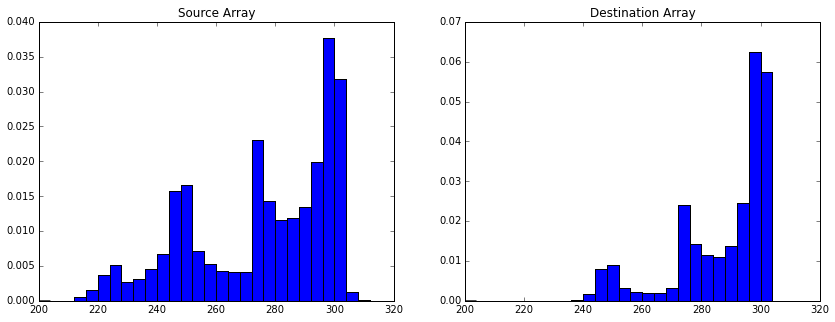

In [8]:
stats(fv1_src_data, gx1_dest_data, range=(200, 320))

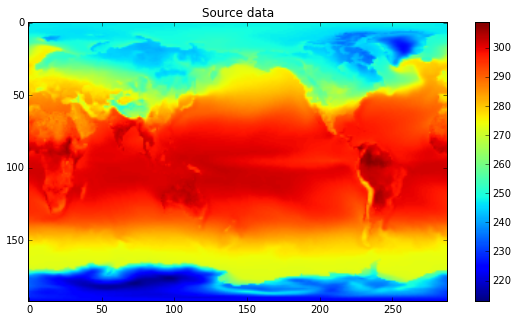

In [9]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_src_data.squeeze()))
plt.colorbar()
plt.title("Source data")
plt.show()

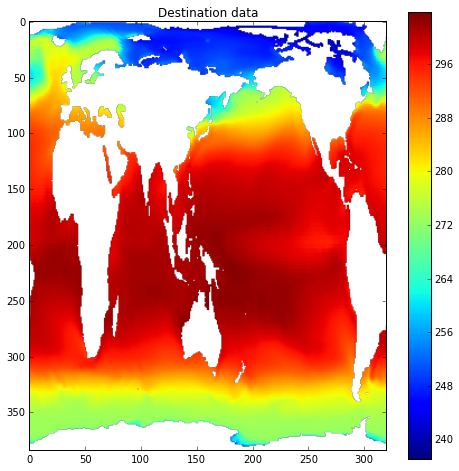

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_dest_data))
plt.colorbar()
plt.title("Destination data")
plt.show()

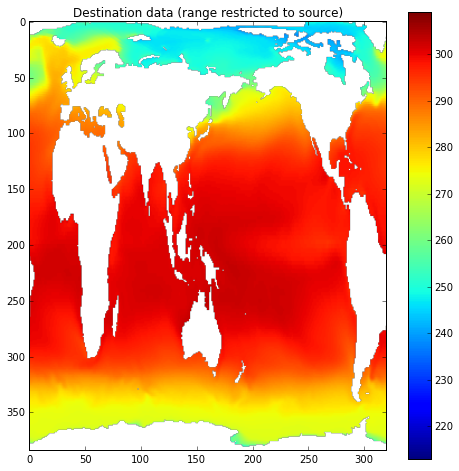

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_dest_data), vmin=fv1_src_data.min(), vmax=fv1_src_data.max())
plt.colorbar()
plt.title("Destination data (range restricted to source)")
plt.show()

## GX1 to FV1

In [12]:
ncfile = Dataset(gx1data['file'], "r")
gx1_src_data = ncfile.variables[gx1data['var']][:,:]
ncfile.close()


fv1_dest_data = scrip.remap(gx1_src_data, a.mapFile('cesmpifv1mts', 'conservative','gx1', 'fv1'))
# fv1_dest_data[np.where(fv1_dest_data == 0) ] = np.nan
# gx1_src_data[np.where(gx1_src_data == 0) ] = np.nan

Array shapes:  (384, 320)     (192, 288)
Minimum     :  -237.680648804     -236.318649992
Mean        :  -9.51669966775     -16.6751322005
Maximum     :  121.562255859     119.597963177
Std         :  82.961865504     71.4357867027


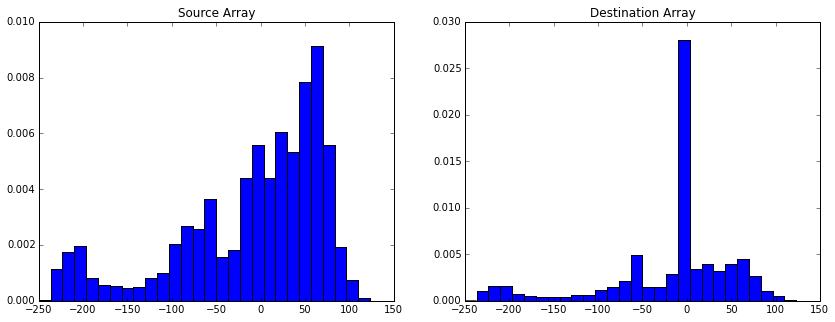

In [13]:
stats(gx1_src_data, fv1_dest_data, range=(-250,150))

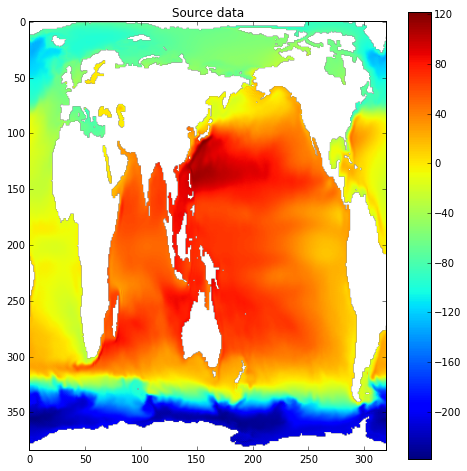

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_src_data.squeeze()))
plt.colorbar()
plt.title("Source data")
plt.show()

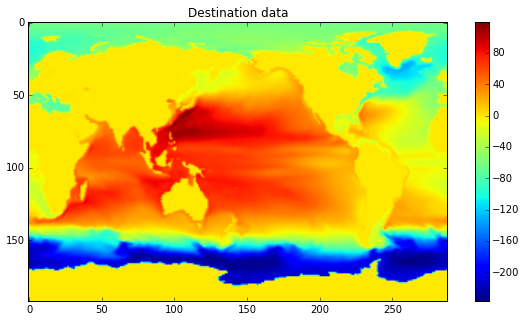

In [15]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_dest_data))
plt.colorbar()
plt.title("Destination data")
plt.show()

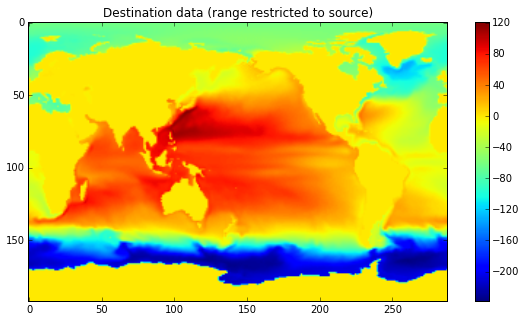

In [16]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_dest_data), vmin=gx1_src_data.min(), vmax=gx1_src_data.max())
plt.colorbar()
plt.title("Destination data (range restricted to source)")
plt.show()

In [17]:
type(gx1_src_data)

numpy.ma.core.MaskedArray

In [18]:
gx1_src_data.mask

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]], dtype=bool)

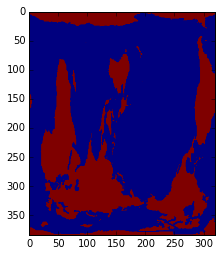

In [19]:
plt.figure()
plt.imshow(gx1_src_data.mask.squeeze().astype('f'))
plt.show()

## FV1 to LL1

In [20]:
ll1_dest_data_from_fv1 = scrip.remap(fv1_src_data, a.mapFile('cesmpifv1mts', 'conservative','fv1', 'll1'))

Array shapes:  (192, 288)     (180, 360)
Minimum     :  213.01789856     213.431956723
Mean        :  275.515106201     275.725707132
Maximum     :  309.005615234     308.67081473
Std         :  23.6378955841     23.486790569


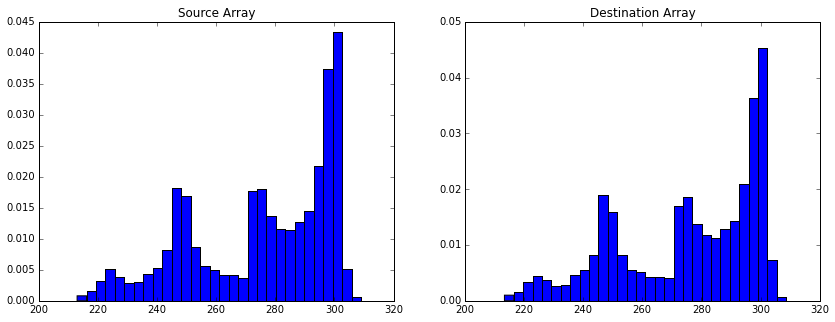

In [21]:
stats(fv1_src_data, ll1_dest_data_from_fv1)

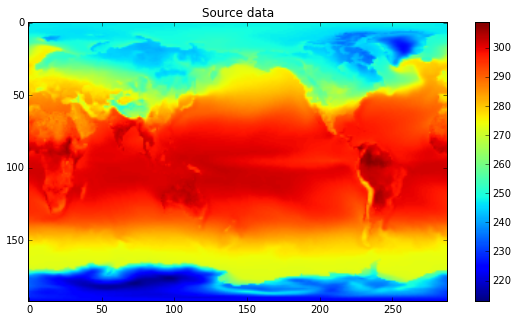

In [22]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_src_data.squeeze()))
plt.colorbar()
plt.title("Source data")
plt.show()

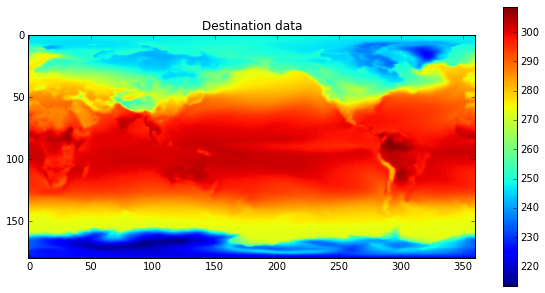

In [23]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(ll1_dest_data_from_fv1))
plt.colorbar()
plt.title("Destination data")
plt.show()

## GX1 to LL1

In [24]:
ll1_dest_data_from_gx1 = scrip.remap(gx1_src_data, a.mapFile('cesmpifv1mts', 'conservative','gx1', 'll1'))
ll1_dest_data_from_gx1 = np.ma.MaskedArray(ll1_dest_data_from_gx1, mask=(ll1_dest_data_from_gx1 == 0))

Array shapes:  (384, 320)     (180, 360)
Minimum     :  -237.680648804     -236.352079246
Mean        :  -9.51669966775     -25.7930302992
Maximum     :  121.562255859     119.508562716
Std         :  82.961865504     87.2815573141


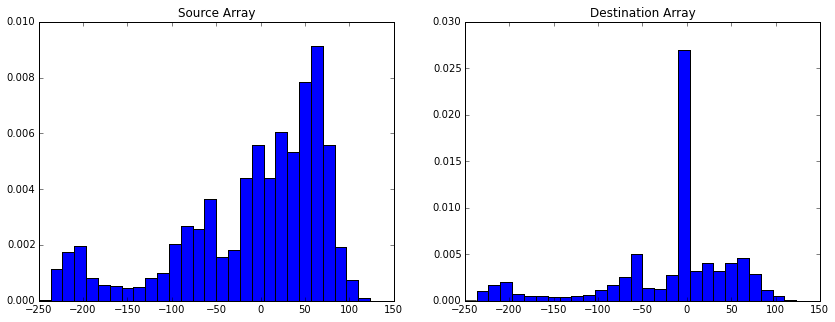

In [25]:
stats(gx1_src_data, ll1_dest_data_from_gx1, range=(-250,150))

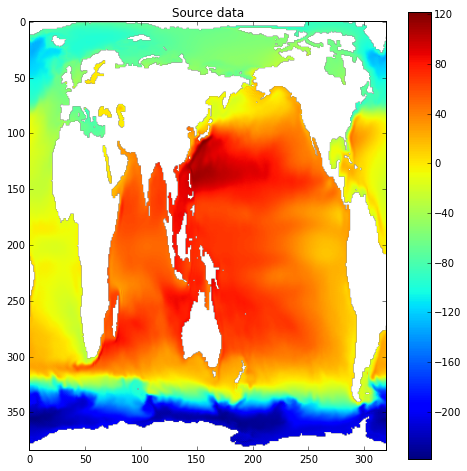

In [26]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_src_data.squeeze()))
plt.colorbar()
plt.title("Source data")
plt.show()

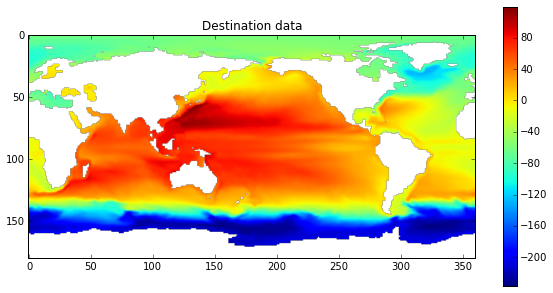

In [27]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(ll1_dest_data_from_gx1))
plt.colorbar()
plt.title("Destination data")
plt.show()

In [28]:
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')

<matplotlib.colorbar.Colorbar instance at 0x11454d320>

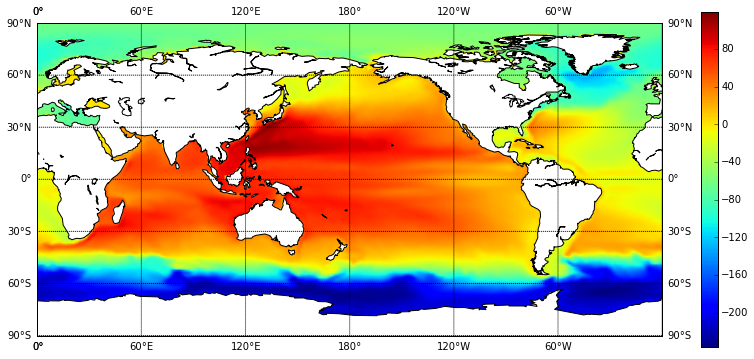

In [29]:
plt.figure(figsize=(14,6))
m.imshow(ll1_dest_data_from_gx1.data)
m.drawcoastlines()
m.fillcontinents(color='white')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.), labels=[True, True, False, False])
m.drawmeridians(np.arange(-180.,181.,60.), labels=[False, False, True, True])
m.drawmapboundary()
plt.colorbar()